In [1]:
!pip install shap


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached numpy-2.1.3-cp312-cp312-macosx_10_13_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 1.6 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 2.2 MB/s eta 0:00:00a 0:00:01
Using cached numpy-2.1.3-cp312-cp312-macosx_10_13_x86_64.whl (20.8 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 2.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.2
    Uninstalling numpy-2.2.2:
      Successfully uninstalled numpy-2.2.2

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

/Users/camryncurtis/Documents/GitHub/Capstone-Project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dataset
df = pd.read_parquet('../data/03_processed/cleaned_data_snappy.parquet')

In [4]:
# Log-transform target variable if right-skewed
df['totalFare'] = np.log1p(df['totalFare'])

In [5]:
# Define features and target
X = df.drop('totalFare', axis=1)  # Features
y = df['totalFare']               # Target variable

In [6]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [7]:
# Ensure all categorical columns are strings
for col in categorical_cols:
    X[col] = X[col].astype(str)  # Convert to string to avoid unhashable errors
    X[col + "_freq"] = X.groupby(col)[col].transform("count")

# Drop original categorical columns
X.drop(columns=categorical_cols, inplace=True)


In [8]:
# Convert any remaining non-numeric columns to numeric codes
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_cols:
    X[col] = X[col].astype("category").cat.codes


In [9]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


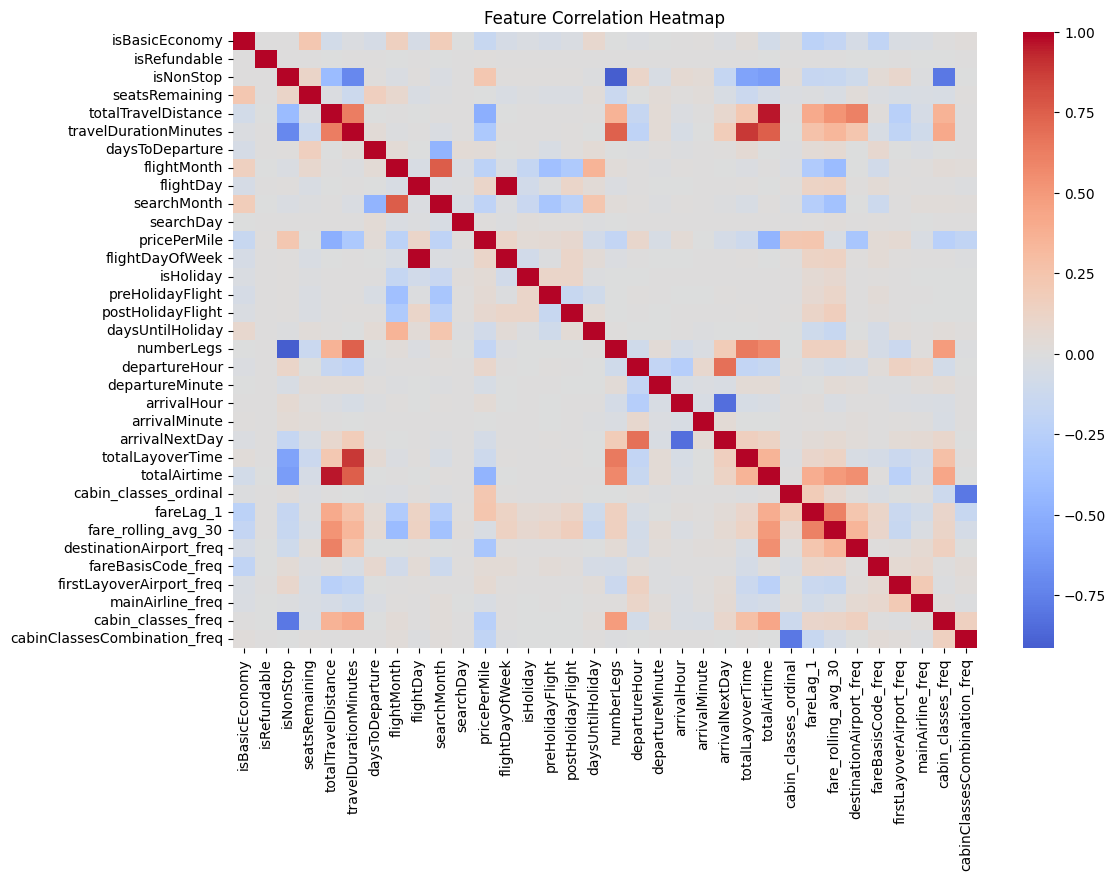

In [10]:
# -----------------------------------
# Feature Selection Step 1: Correlation Analysis
# -----------------------------------
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [11]:
# Drop highly correlated features (optional: set threshold > 0.85)
correlation_matrix = X_train.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))


In [12]:
# Drop features with correlation higher than threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
X_train.drop(columns=to_drop, inplace=True)
X_val.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

In [13]:
# -----------------------------------
# Train Initial Random Forest Model
# -----------------------------------
rf = RandomForestRegressor(random_state=42)

In [14]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt']
}

In [15]:
# Use RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_grid,
    n_iter=5, cv=2, scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=1, random_state=42
)

In [16]:
# Train on a **subset** of training data for speed
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)
random_search.fit(X_sample, y_sample)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 5],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [20, 50, 100]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [17]:
# Best model
best_rf = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}


In [18]:
# Train best model on full dataset
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=50, random_state=42)

In [19]:
# -----------------------------------
# Feature Selection Step 2: Permutation Importance
# -----------------------------------
perm_importance = permutation_importance(best_rf, X_val, y_val, n_repeats=5, random_state=42)


In [20]:
# Store results in DataFrame
perm_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

In [21]:
# Display top features
print("Top 10 Most Important Features (Permutation Importance):")
print(perm_importance_df.head(10))

Top 10 Most Important Features (Permutation Importance):
                    Feature  Importance
11             pricePerMile    0.454123
22                fareLag_1    0.198718
4       totalTravelDistance    0.107094
5     travelDurationMinutes    0.077916
24  destinationAirport_freq    0.028025
23      fare_rolling_avg_30    0.014304
25       fareBasisCode_freq    0.009884
0            isBasicEconomy    0.009456
2                 isNonStop    0.006774
27         mainAirline_freq    0.006261


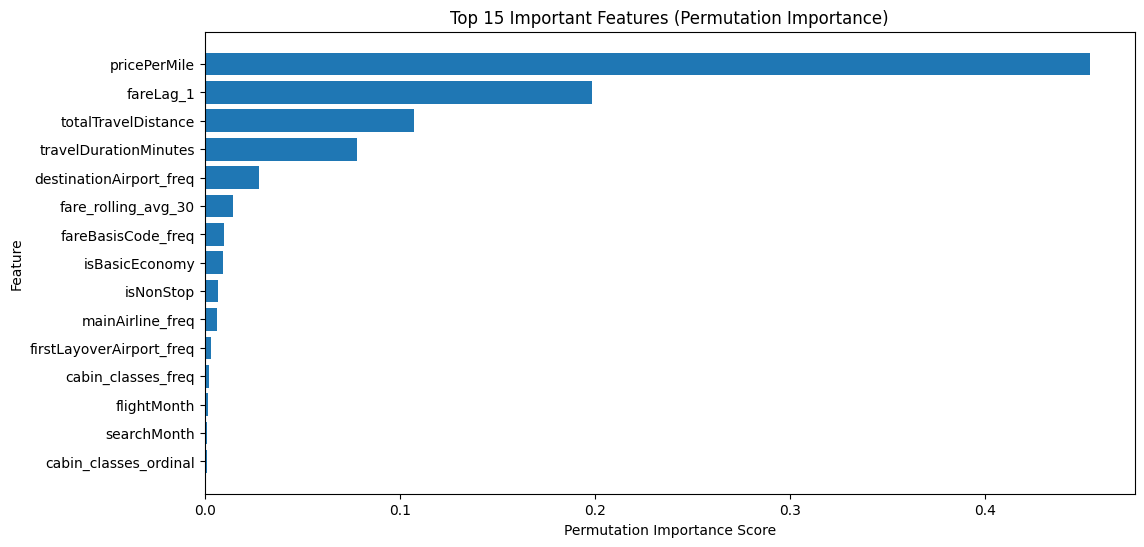

In [22]:
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(perm_importance_df["Feature"][:15], perm_importance_df["Importance"][:15])
plt.xlabel("Permutation Importance Score")
plt.ylabel("Feature")
plt.title("Top 15 Important Features (Permutation Importance)")
plt.gca().invert_yaxis()
plt.show()

In [23]:
# -----------------------------------
# Feature Selection Step 3: SHAP Analysis
# -----------------------------------

# Sample a smaller dataset for SHAP to reduce memory load
X_train_sample = X_train.sample(500, random_state=42)  # Reduce training data for SHAP explainer
X_val_sample = X_val.sample(500, random_state=42)  # Reduce validation data for SHAP calculations


In [24]:
# Use SHAP's optimized TreeExplainer (better for Random Forest models)
explainer = shap.TreeExplainer(best_rf)

In [25]:
# Compute SHAP values only for the sampled validation set
shap_values = explainer.shap_values(X_val_sample)

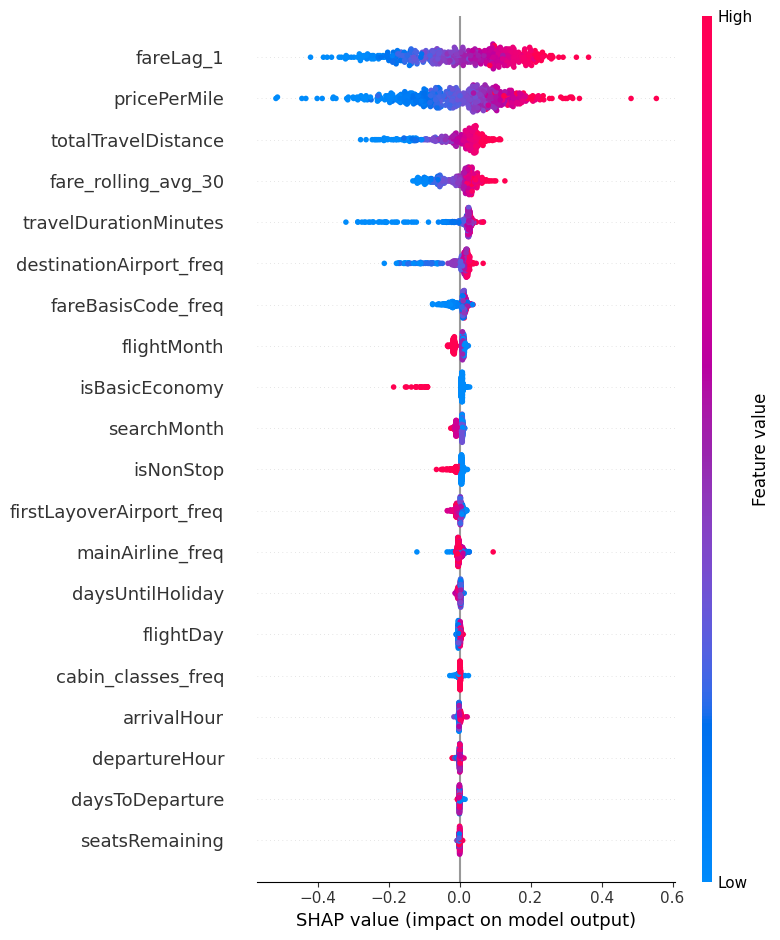

In [26]:
# SHAP Summary Plot using the exact same subset
shap.summary_plot(shap_values, X_val_sample)

In [27]:
# -----------------------------------
# Feature Reduction: Keep Only Important Features
# -----------------------------------
importance_threshold = 0.002  
important_features = perm_importance_df[perm_importance_df["Importance"] > importance_threshold]["Feature"]


In [28]:
# Reduce dataset
X_train_reduced = X_train[important_features]
X_val_reduced = X_val[important_features]
X_test_reduced = X_test[important_features]


In [ ]:
# -----------------------------------
# Retrain Model with Reduced Features
# -----------------------------------
rf_reduced = RandomForestRegressor(random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

In [32]:
# Predict and Evaluate
y_val_pred = rf_reduced.predict(X_val_reduced)
y_test_pred = rf_reduced.predict(X_test_reduced)


In [33]:
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Validation MSE (Reduced Features): {val_mse}')
print(f'Test MSE (Reduced Features): {test_mse}')


Validation MSE (Reduced Features): 5.2262979049910597e-05
Test MSE (Reduced Features): 6.470761241247452e-05


In [34]:
# -----------------------------------
# Convert Metrics Back to Real Scale
# -----------------------------------
validation_rmse_real = np.expm1(np.sqrt(val_mse))
test_rmse_real = np.expm1(np.sqrt(test_mse))


print(f"Validation RMSE (real currency): ${validation_rmse_real:.4f}")
print(f"Test RMSE (real currency): ${test_rmse_real:.4f}")

Validation RMSE (real currency): $0.0073
Test RMSE (real currency): $0.0081


In [35]:
# -----------------------------------
# Calculate R² Score
# -----------------------------------
r2 = r2_score(y_test, y_test_pred)
print(f'Test R² Score: {r2:.4f}')

Test R² Score: 0.9997


In [ ]:
# Save the trained model in the 'models' folder

models_dir = "models"
os.makedirs(models_dir, exist_ok=True)  # Ensure the directory exists

model_filename = os.path.join(models_dir, "random_forest.pkl")
joblib.dump(rf_reduced, model_filename)
print(f"Model saved as {model_filename}")


In [ ]:
# Define test data directory for Random Forest
rf_test_data_dir = "test_data/RandomForest"
os.makedirs(rf_test_data_dir, exist_ok=True)  # Ensure directory exists

# Save test data for Random Forest
joblib.dump(X_test_reduced, os.path.join(rf_test_data_dir, "X_test_rf.pkl"))
joblib.dump(y_test, os.path.join(rf_test_data_dir, "y_test_rf.pkl"))
print("Test data saved in 'test_data/RandomForest/' for Random Forest.")
